# Dependencies

In [1]:
%%capture
!pip install pandas
!pip install pyarrow
!pip install tensorflow
!pip install protobuf==3.20.*
!pip install mediapipe==0.9.0.1

In [2]:
import os
import json
import shutil
import random
import matplotlib
import numpy as np
from itertools import chain
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import animation, rc
from IPython.display import display, Image

import cv2
import pandas as pd
import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
import pyarrow.parquet as pq
from tensorflow.keras import layers
from mediapipe.framework.formats import landmark_pb2

In [3]:
!python --version
print("TensorFlow v" + tf.__version__)
print("Mediapipe v" + mp.__version__)

Python 3.9.13
TensorFlow v2.14.0
Mediapipe v0.9.0.1


In [4]:
random.seed(42)

# Load data

In [5]:
dataset_df = pd.read_csv('kaggle_dataset/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (67208, 5)


In [6]:
dataset_df.head()

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


In [7]:
def random_sequence():
    # Fetch sequence_id, file_id, phrase from first row
    sequence_id, file_id, phrase, path = dataset_df.sample(n=1).iloc[0][['sequence_id', 'file_id', 'phrase', 'path']]
    print(f"sequence_id: {sequence_id}, file_id: {file_id}, phrase: {phrase}")
    
    # Fetch data from parquet file
    sample_sequence_df = pq.read_table(f"kaggle_dataset/{path}",
        filters=[[('sequence_id', '=', sequence_id)],]).to_pandas()
    print("Full sequence dataset shape is {}".format(sample_sequence_df.shape))
    
    return sample_sequence_df

In [8]:
random_sequence()

sequence_id: 747520844, file_id: 638508439, phrase: +598-04-61-233
Full sequence dataset shape is (155, 1630)


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
747520844,0,0.728761,0.714538,0.720425,0.701241,0.712665,0.712150,0.712393,0.627954,0.710045,...,-0.119405,-0.118685,-0.058785,-0.109231,-0.105707,-0.093436,-0.073750,-0.109252,-0.107562,-0.097809
747520844,1,0.734500,0.716403,0.722434,0.702830,0.714402,0.713744,0.713707,0.627412,0.711290,...,-0.098566,-0.100498,-0.041302,-0.084254,-0.086690,-0.077932,-0.051984,-0.082380,-0.083064,-0.074851
747520844,2,0.734276,0.712490,0.718955,0.699747,0.710568,0.710290,0.711341,0.629053,0.709473,...,-0.086528,-0.085980,-0.031518,-0.081384,-0.081711,-0.068241,-0.043483,-0.080777,-0.078784,-0.065607
747520844,3,0.734017,0.713917,0.720447,0.700820,0.711892,0.711452,0.712181,0.630108,0.710037,...,-0.088455,-0.084312,-0.034433,-0.086200,-0.084447,-0.068323,-0.046832,-0.086064,-0.084942,-0.071649
747520844,4,0.737471,0.716697,0.722984,0.703581,0.714794,0.714339,0.714893,0.631179,0.712946,...,-0.086822,-0.081269,-0.034435,-0.087378,-0.085626,-0.069017,-0.047203,-0.086519,-0.086342,-0.074011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747520844,150,0.758438,0.740701,0.746727,0.728420,0.738994,0.738977,0.740728,0.655828,0.739409,...,-0.115488,-0.129020,-0.043919,-0.110820,-0.125467,-0.116909,-0.052765,-0.114300,-0.125307,-0.118458
747520844,151,0.759593,0.744821,0.750772,0.731925,0.743110,0.742854,0.743795,0.654516,0.741966,...,-0.123619,-0.139182,-0.049871,-0.117667,-0.145962,-0.149218,-0.049700,-0.116726,-0.138960,-0.142121
747520844,152,0.759810,0.743436,0.749319,0.730935,0.741790,0.741637,0.742892,0.656227,0.741444,...,-0.129802,-0.144117,-0.051674,-0.121718,-0.139672,-0.132821,-0.058457,-0.123303,-0.136005,-0.130002


## Animation preview

In [15]:
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['savefig.pad_inches'] = 0
rc('animation', html='jshtml')

def create_animation(images):
    fig = plt.figure(figsize=(6, 9))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im=ax.imshow(images[0], cmap="gray")
    plt.close(fig)
    
    def animate_func(i):
        im.set_array(images[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(images), interval=1000/10)

mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

def collect_landmarks_oftype(_type: str, frame_data: pd.Series):
    x_type = frame_data.filter(regex=f"x_{_type}.*").values
    y_type = frame_data.filter(regex=f"y_{_type}.*").values
    z_type = frame_data.filter(regex=f"z_{_type}.*").values
    landmarks = landmark_pb2.NormalizedLandmarkList()
    for x, y, z in zip(x_type, y_type, z_type):
        landmarks.landmark.add(x=x, y=y, z=z)
    return landmarks
        
def produce_video_from_seq(seq_df: pd.DataFrame):
    frames = []
    for seq_idx in range(len(seq_df)):
        frame = np.zeros((600, 600, 3))
        frame_data = seq_df.iloc[seq_idx]
        
        # Right hand
        right_hand_landmarks = collect_landmarks_oftype("right_hand", frame_data)
        mp_drawing.draw_landmarks(
                frame,
                right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        # Left Hand
        left_hand_landmarks = collect_landmarks_oftype("left_hand", frame_data)
        mp_drawing.draw_landmarks(
                frame,
                left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        # Face
        face_landmarks = collect_landmarks_oftype("face", frame_data)
        mp_drawing.draw_landmarks(
            frame,
            face_landmarks,
            mp_holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        
        # Pose
        pose_landmarks = collect_landmarks_oftype("pose", frame_data)
        mp_drawing.draw_landmarks(
            frame,
            pose_landmarks,
            mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.
            get_default_pose_landmarks_style())
        
        frames.append(frame.astype(np.uint8))
    return frames

In [16]:
video = produce_video_from_seq(random_sequence())
create_animation(video)

sequence_id: 1926120986, file_id: 1365772051, phrase: 1311 palmyra port gibson
Full sequence dataset shape is (39, 1630)


# Statistics

In [24]:
def lengths_hist(lengths: list, title="", space=50):
    plt.hist(lengths, np.linspace(0, space, space))
    plt.ylim(plt.ylim())
    max_length = max(lengths)
    plt.plot([max_length, max_length], plt.ylim())
    plt.title(f'{title} (Max: {max_length})')
    plt.show()

def calc_percentiles(values: list, percentiles=[25, 50,75, 80, 90]):
    percentile_values = np.percentile(values, percentiles)
    for p, value in zip(percentiles, percentile_values):
        print(f"{p}th percentile: {value}")

## Statistics on the length of phrases:

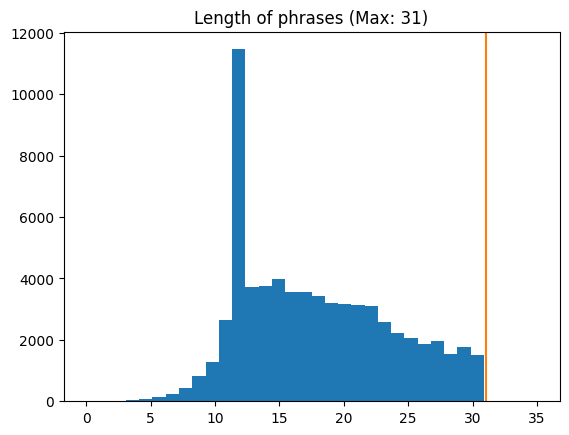

25th percentile: 12.0
50th percentile: 17.0
75th percentile: 22.0
80th percentile: 23.0
90th percentile: 27.0


In [25]:
phrase_lengths = []
def gather_lenghts(phrase: str):
    phrase_lengths.append(len(phrase))
    return phrase
dataset_df.phrase.apply(gather_lenghts)

lengths_hist(phrase_lengths, "Length of phrases", 35)
calc_percentiles(phrase_lengths)

## Statistics on the length of sequences:

  0%|          | 0/68 [00:00<?, ?it/s]

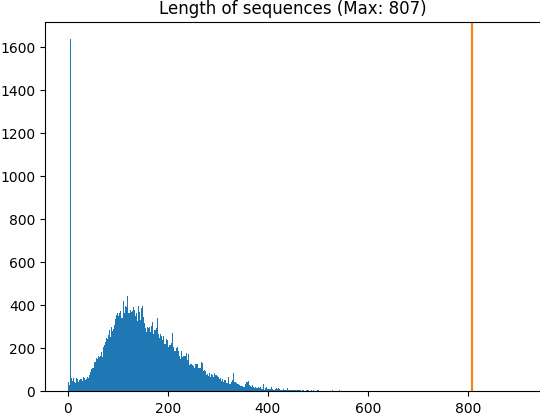

25th percentile: 104.0
50th percentile: 148.0
75th percentile: 207.0
80th percentile: 223.0
90th percentile: 270.0


In [78]:
seq_lengths = []
for file_path in tqdm(dataset_df.path.unique()):
    pq_file = f"kaggle_dataset/{file_path}"
    seq_lengths.extend(list(pq.read_table(pq_file,columns=['sequence_id']).to_pandas().index.to_series().value_counts()))

lengths_hist(seq_lengths, "Length of sequences", 900)

calc_percentiles(seq_lengths)

What's interesting to note is that there are many cases where the sequence is only a few frames long. This would be normal if the phrase associated with the sequence also a had short length. But the statistics about the phrase lengths show that there aren't as many.
Also from the animation preview, it is clear that in many frames the detailed hand landmarks are not available.

To fix these issues a heuristic needs to be applied:
    - Calculate how many frames the dominant hand is visible
    - Require at least two frames per character in the associated phrase

  0%|          | 0/68 [00:00<?, ?it/s]

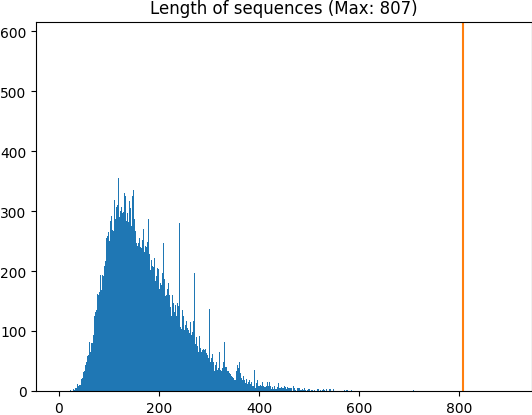

25th percentile: 104.0
50th percentile: 148.0
75th percentile: 207.0
80th percentile: 223.0
90th percentile: 270.0


In [79]:
seq_lengths_filtered = []
for file_path in tqdm(dataset_df.path.unique()):
    pq_file = f"kaggle_dataset/{file_path}"
    # For some reason the next two lines cannot be placed in a single line as it results in an error
    # If anyone figures out what can cause that contact me:)
    parquet_df = pq.read_table(pq_file, columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()
    parquet_numpy = parquet_df.to_numpy()
    
    parts = file_path.split('/')
    last_part = parts[-1]
    number_string = last_part.split('.')[0]
    file_id = int(number_string)
    
    # Filter train.csv and fetch entries only for the relevant file_id
    file_df = dataset_df.loc[dataset_df["file_id"] == file_id]
    
    for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
        # Fetch sequence data
        frames = parquet_numpy[parquet_df.index == seq_id]
        # Calculate the number of rows that only have NaN values -> on how many frames each hand is fully visible
        r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
        l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
        # Number of frames where the dominant hand is visible (dominant = visible on more frames than the other hand)
        num_of_visible = max(r_nonan, l_nonan)
        # TODO experiment with this
        if 2*len(phrase) < num_of_visible:
            seq_lengths_filtered.append(len(frames))

lengths_hist(seq_lengths_filtered, "Length of sequences", 900)
calc_percentiles(seq_lengths)

The models input will be the padded sequences. It's an iteresting optimization task as cutting off at lower lengths wastes data, but saves computation time.

# Save to TFRecords

In [9]:
# Pose coordinates for hand movement.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

FEATURE_COLUMNS = X + Y + Z

X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in LPOSE]

In [10]:
def save_tfrecords_to(folder: str):
    # Loop through each file_id
    for file_path in tqdm(dataset_df.path.unique()):
        # Parquet file name
        pq_file = f"kaggle_dataset/{file_path}"
        
        parts = file_path.split('/')
        last_part = parts[-1]
        number_string = last_part.split('.')[0]
        file_id = int(number_string)
        
        # Filter train.csv and fetch entries only for the relevant file_id
        file_df = dataset_df.loc[dataset_df["file_id"] == file_id]
        # Fetch the parquet file
        parquet_df = pq.read_table(pq_file,columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()

        # File name for the updated data
        tf_file = f"{folder}/{file_id}.tfrecord"
        parquet_numpy = parquet_df.to_numpy()
        # Initialize the pointer to write the output of each `for loop` below as a sequence into the file.
        with tf.io.TFRecordWriter(tf_file) as file_writer:
            # Loop through each sequence in file.
            for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
                # Fetch sequence data
                frames = parquet_numpy[parquet_df.index == seq_id]

                # Calculate the number of rows that only have NaN values -> on how many frames each hand is fully visible
                r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
                l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
                # Number of frames where the dominant hand is visible (dominant = visible on more frames than the other hand)
                num_of_visible = max(r_nonan, l_nonan)

                # TODO experiment with this
                if 2*len(phrase) < num_of_visible:
                    features = {FEATURE_COLUMNS[i]: tf.train.Feature(float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(FEATURE_COLUMNS))}
                    features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
                    record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                    file_writer.write(record_bytes)

In [10]:
folder_name = "train_tfrecords"
if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
    save_tfrecords_to(folder_name)
else:
    print(f"Warning: Tfrecords already exist! Delete the {folder_name} folder to regenerate them!")

# Fetch from TFRecords

In [11]:
tf_records = dataset_df.file_id.map(lambda x: f'{folder_name}/{x}.tfrecord').unique()
print(f"List of {len(tf_records)} TFRecord files.")

List of 68 TFRecord files.


In [12]:
# The default mapping that came with the dataset was changed:
# padding is represented with the number 0
# start_token is 60
# end_token is 61
with open ("kaggle_dataset/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)

# Add pad_token, start pointer and end pointer to the dict
pad_token = 'P'
start_token = '<'
end_token = '>'
pad_token_idx = char_to_num[pad_token]
start_token_idx = char_to_num[start_token]
end_token_idx = char_to_num[end_token]

num_to_char = {j:i for i,j in char_to_num.items()}

In [13]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

In [14]:
FRAME_LEN = 256
MAX_PHRASE_LEN = 32

# Function to resize and add padding.
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

# Detect the dominant hand from the number of NaN values.
# Dominant hand will have less NaN values since it is in frame moving.
def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # For dominant hand
    if rnans > lnans:
        hand = lhand
        pose = lpose
        
        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)
        
        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
    else:
        hand = rhand
        pose = rpose
    
    hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
    hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
    hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)
    
    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std

    pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
    pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
    pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)
    
    x = tf.concat([hand, pose], axis=1)
    x = resize_pad(x)
    
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    return x

table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def convert_fn(landmarks, phrase):
    # Add start and end pointers to phrase.
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    
    max_len_plus = MAX_PHRASE_LEN + 1
    amount_to_pad = max_len_plus - tf.shape(phrase)[0]
    
    if amount_to_pad > 0:
        phrase = tf.pad(phrase, paddings=[[0, amount_to_pad]], mode = 'CONSTANT', constant_values = pad_token_idx)
    else:
        phrase = phrase[:max_len_plus]
    
    return (pre_process(landmarks), phrase[:-1]), phrase[1:]

In [15]:
batch_size = 32
train_len = int(0.8 * len(tf_records))
shuffle_buffer_size = 4*batch_size

train_ds = tf.data.TFRecordDataset(tf_records[:train_len]).map(decode_fn).map(convert_fn).batch(batch_size).shuffle(buffer_size=shuffle_buffer_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
valid_ds = tf.data.TFRecordDataset(tf_records[train_len:]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

In [16]:
lm_shape = None
phrase_shape = None

# Create an iterator for the train and valid datasets
train_iterator = iter(train_ds)

# Print data points from the training dataset
print("Training Data:\n")
(landmarks, context), phrase = next(train_iterator)

# Save shapes
lm_shape = landmarks.shape[2]
phrase_shape = phrase.shape[0]
print("Saved shapes:")
print(f"lm_shape: {lm_shape}")
print(f"phrase_shape: {phrase_shape}")
print("-" * 40)

print("Encoder input (Landmarks:)")
print(type(landmarks))
print(landmarks.shape)
print(landmarks[0])
print("-" * 40)

print("Decoder input (Context):")
print(context.shape)
print(context[0])
print("-" * 40)

print("Model target output (Phrase):")
print(phrase.shape)
print(phrase[0])
print("-" * 40)

Training Data:

Saved shapes:
lm_shape: 78
phrase_shape: 32
----------------------------------------
Encoder input (Landmarks:)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 256, 78)
tf.Tensor(
[[-0.31076375  1.9238192   2.7320406  ...  0.26993796  0.7908722
  -4.048988  ]
 [-0.2595654   2.0778959   2.6200442  ...  0.2995561   0.78658056
  -4.102775  ]
 [-0.3262525   2.0024276   2.4517932  ...  0.30452415  0.7753266
  -4.323896  ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(256, 78), dtype=float32)
----------------------------------------
Decoder input (Context):
(32, 32)
tf.Tensor(
[60 23 21 21 23 24 16  1 40 33 50 50 41 51  1 51 53 34 36 41 54 41 51 41
 47 46 61  0  0  0  0  0], shape=(32,), dtype=int32)
----------------------------------------
Model target output (Phrase):
(32, 32)
tf

# Transformer model

## Model creation

In [22]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
    
    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalTokenEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, max_future_input_size):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=max_future_input_size, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

class PositionalLandmarkEmbedding(tf.keras.layers.Layer):
    def __init__(self, len_of_seq, d_model, num_conv_layers, filter_size):
        super().__init__()
        self.d_model = d_model
        self.len_of_seq = len_of_seq
        # maybe add input for Convs
        self.conv_block = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(d_model, filter_size, padding="same", activation="relu")
            for _ in range(num_conv_layers)
        ])
        self.pos_encoding = positional_encoding(length=len_of_seq, depth=d_model)
        
    def call(self, x):
        #length = tf.shape(x)[1]
        x = self.conv_block(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # print(self.pos_encoding[tf.newaxis, :self.len_of_seq, :].shape) # (1, 128, 512) this isnt semantically correct
        x = x + self.pos_encoding[tf.newaxis, :self.len_of_seq, :]
        return x
    
class Seq2SeqLSTM(tf.keras.Model):
    def __init__(self, *, len_lm_seq, num_conv_layers, filter_size, d_model, input_vocab_size, target_vocab_size, max_future_input_size, dropout_rate=0.1):
        super().__init__()

        self.enc_pos_embedding = PositionalLandmarkEmbedding(len_lm_seq, d_model, num_conv_layers, filter_size)
        self.enc_dropout = tf.keras.layers.Dropout(dropout_rate)
        self.enc_LSTM = tf.keras.layers.LSTM(d_model, return_state=True)
        
        self.dec_pos_embedding = PositionalTokenEmbedding(vocab_size=input_vocab_size, d_model=d_model, max_future_input_size=max_future_input_size)
        self.dec_dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_LSTM = tf.keras.layers.LSTM(d_model, return_state=True, return_sequences=True)
    
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        # outputs = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'))(decoder_outputs)

    def call(self, inputs):
        landmark_seq, prev_gen_ctx  = inputs
    
        encoded_lm_seq = self.enc_pos_embedding(landmark_seq)
        encoded_lm_seq = self.enc_dropout(encoded_lm_seq)
        encoder_outputs, state_h, state_c = self.enc_LSTM(encoded_lm_seq)

        embedded_ctx = self.dec_pos_embedding(prev_gen_ctx)
        embedded_ctx = self.enc_dropout(embedded_ctx)
        decoder_outputs, _, _ = self.dec_LSTM(embedded_ctx, initial_state=[state_h, state_c])
        
        logits = self.final_layer(decoder_outputs)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass
    
        return logits

In [23]:
d_model = 256 # embedding size
max_future_input_size = MAX_PHRASE_LEN  # In the future the input can be longer than what it's trained on

seq2seq_model = Seq2SeqLSTM(
    len_lm_seq=FRAME_LEN,
    num_conv_layers=3,
    filter_size=11,
    d_model=d_model,
    input_vocab_size=len(char_to_num),
    target_vocab_size=len(char_to_num),
    max_future_input_size=max_future_input_size,
    dropout_rate=0.1)

In [25]:
# Example inference to build the model
(lm, ctx), _label = next(iter(train_ds))
output = seq2seq_model((lm, ctx))

print(lm.shape)
print(ctx.shape)
print(output.shape)

seq2seq_model.summary()

(32, 256, 78)
(32, 32)
(32, 32, 62)
Model: "seq2_seq_lstm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_landmark_embedd  multiple                  1662208   
 ing_1 (PositionalLandmarkE                                      
 mbedding)                                                       
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 lstm (LSTM)                 multiple                  525312    
                                                                 
 positional_token_embedding  multiple                  15872     
  (PositionalTokenEmbedding                                      
 )                                                               
                                                                 
 dropout_2 (Dro

## Training

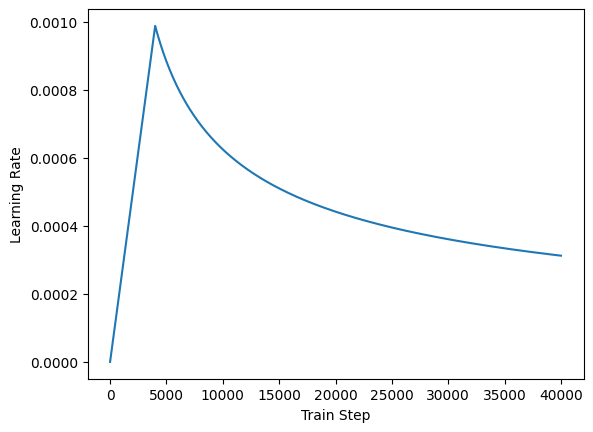

In [28]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
    
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [29]:
def masked_loss(label, pred):
    mask = label != pad_token_idx
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != pad_token_idx

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [31]:
seq2seq_model.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [32]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='seq2seq_model_weights_checkpoint.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=2
)

In [21]:
# %%time
# transformer.fit(train_ds,
#                 validation_data=valid_ds,
#                 epochs=30,
#                 callbacks=[checkpoint_callback],
#                 verbose = 2)

In [ ]:
Epoch 1/20

Epoch 1: val_loss improved from inf to 2.35214, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 140s - loss: 2.8293 - masked_accuracy: 0.2098 - val_loss: 2.3521 - val_masked_accuracy: 0.2946 - 140s/epoch - 111ms/step
Epoch 2/20

Epoch 2: val_loss improved from 2.35214 to 2.14052, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 64s - loss: 2.2375 - masked_accuracy: 0.3197 - val_loss: 2.1405 - val_masked_accuracy: 0.3471 - 64s/epoch - 51ms/step
Epoch 3/20

Epoch 3: val_loss improved from 2.14052 to 1.99580, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 63s - loss: 2.0647 - masked_accuracy: 0.3680 - val_loss: 1.9958 - val_masked_accuracy: 0.3902 - 63s/epoch - 50ms/step
Epoch 4/20

Epoch 4: val_loss improved from 1.99580 to 1.87133, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 62s - loss: 1.9208 - masked_accuracy: 0.4124 - val_loss: 1.8713 - val_masked_accuracy: 0.4291 - 62s/epoch - 49ms/step
Epoch 5/20

Epoch 5: val_loss improved from 1.87133 to 1.81366, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 63s - loss: 1.8091 - masked_accuracy: 0.4461 - val_loss: 1.8137 - val_masked_accuracy: 0.4479 - 63s/epoch - 50ms/step
Epoch 6/20

Epoch 6: val_loss improved from 1.81366 to 1.73752, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 62s - loss: 1.7284 - masked_accuracy: 0.4700 - val_loss: 1.7375 - val_masked_accuracy: 0.4709 - 62s/epoch - 49ms/step
Epoch 7/20

Epoch 7: val_loss improved from 1.73752 to 1.69962, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 65s - loss: 1.6629 - masked_accuracy: 0.4890 - val_loss: 1.6996 - val_masked_accuracy: 0.4828 - 65s/epoch - 51ms/step
Epoch 8/20

Epoch 8: val_loss improved from 1.69962 to 1.66101, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 63s - loss: 1.6073 - masked_accuracy: 0.5053 - val_loss: 1.6610 - val_masked_accuracy: 0.4937 - 63s/epoch - 50ms/step
Epoch 9/20

Epoch 9: val_loss improved from 1.66101 to 1.63128, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 63s - loss: 1.5573 - masked_accuracy: 0.5200 - val_loss: 1.6313 - val_masked_accuracy: 0.5025 - 63s/epoch - 50ms/step
Epoch 10/20

Epoch 10: val_loss improved from 1.63128 to 1.60701, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 63s - loss: 1.5171 - masked_accuracy: 0.5324 - val_loss: 1.6070 - val_masked_accuracy: 0.5117 - 63s/epoch - 50ms/step
Epoch 11/20

Epoch 11: val_loss improved from 1.60701 to 1.58705, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 62s - loss: 1.4777 - masked_accuracy: 0.5443 - val_loss: 1.5870 - val_masked_accuracy: 0.5172 - 62s/epoch - 49ms/step
Epoch 12/20

Epoch 12: val_loss improved from 1.58705 to 1.56979, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 62s - loss: 1.4447 - masked_accuracy: 0.5538 - val_loss: 1.5698 - val_masked_accuracy: 0.5227 - 62s/epoch - 49ms/step
Epoch 13/20

Epoch 13: val_loss improved from 1.56979 to 1.55880, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 60s - loss: 1.4123 - masked_accuracy: 0.5636 - val_loss: 1.5588 - val_masked_accuracy: 0.5274 - 60s/epoch - 47ms/step
Epoch 14/20

Epoch 14: val_loss improved from 1.55880 to 1.54515, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 63s - loss: 1.3827 - masked_accuracy: 0.5725 - val_loss: 1.5452 - val_masked_accuracy: 0.5336 - 63s/epoch - 50ms/step
Epoch 15/20

Epoch 15: val_loss improved from 1.54515 to 1.53530, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 63s - loss: 1.3567 - masked_accuracy: 0.5803 - val_loss: 1.5353 - val_masked_accuracy: 0.5369 - 63s/epoch - 50ms/step
Epoch 16/20

Epoch 16: val_loss improved from 1.53530 to 1.53161, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 59s - loss: 1.3317 - masked_accuracy: 0.5881 - val_loss: 1.5316 - val_masked_accuracy: 0.5390 - 59s/epoch - 47ms/step
Epoch 17/20

Epoch 17: val_loss improved from 1.53161 to 1.52362, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 60s - loss: 1.3068 - masked_accuracy: 0.5955 - val_loss: 1.5236 - val_masked_accuracy: 0.5417 - 60s/epoch - 47ms/step
Epoch 18/20

Epoch 18: val_loss improved from 1.52362 to 1.51798, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 63s - loss: 1.2860 - masked_accuracy: 0.6025 - val_loss: 1.5180 - val_masked_accuracy: 0.5454 - 63s/epoch - 50ms/step
Epoch 19/20

Epoch 19: val_loss improved from 1.51798 to 1.51251, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 60s - loss: 1.2643 - masked_accuracy: 0.6088 - val_loss: 1.5125 - val_masked_accuracy: 0.5491 - 60s/epoch - 47ms/step
Epoch 20/20

Epoch 20: val_loss improved from 1.51251 to 1.51186, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 57s - loss: 1.2445 - masked_accuracy: 0.6156 - val_loss: 1.5119 - val_masked_accuracy: 0.5502 - 57s/epoch - 45ms/step
CPU times: user 21min 31s, sys: 1min 6s, total: 22min 38s
Wall time: 25min 40s
<keras.callbacks.History at 0x7ee928303850>

    Epoch 1/20

Epoch 1: val_loss improved from 1.51186 to 1.50952, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 64s - loss: 1.2251 - masked_accuracy: 0.6211 - val_loss: 1.5095 - val_masked_accuracy: 0.5535 - 64s/epoch - 51ms/step
Epoch 2/20

Epoch 2: val_loss did not improve from 1.50952
1263/1263 - 63s - loss: 1.2062 - masked_accuracy: 0.6273 - val_loss: 1.5155 - val_masked_accuracy: 0.5528 - 63s/epoch - 50ms/step
Epoch 3/20

Epoch 3: val_loss improved from 1.50952 to 1.50760, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 62s - loss: 1.1890 - masked_accuracy: 0.6328 - val_loss: 1.5076 - val_masked_accuracy: 0.5567 - 62s/epoch - 49ms/step
Epoch 4/20

Epoch 4: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.1721 - masked_accuracy: 0.6376 - val_loss: 1.5102 - val_masked_accuracy: 0.5574 - 62s/epoch - 49ms/step
Epoch 5/20

Epoch 5: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.1571 - masked_accuracy: 0.6425 - val_loss: 1.5159 - val_masked_accuracy: 0.5569 - 62s/epoch - 49ms/step
Epoch 6/20

Epoch 6: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.1408 - masked_accuracy: 0.6472 - val_loss: 1.5198 - val_masked_accuracy: 0.5572 - 62s/epoch - 49ms/step
Epoch 7/20

Epoch 7: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.1262 - masked_accuracy: 0.6521 - val_loss: 1.5226 - val_masked_accuracy: 0.5587 - 62s/epoch - 49ms/step
Epoch 8/20

Epoch 8: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.1131 - masked_accuracy: 0.6558 - val_loss: 1.5269 - val_masked_accuracy: 0.5590 - 62s/epoch - 49ms/step
Epoch 9/20

Epoch 9: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.0978 - masked_accuracy: 0.6608 - val_loss: 1.5258 - val_masked_accuracy: 0.5607 - 62s/epoch - 49ms/step
Epoch 10/20

Epoch 10: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.0859 - masked_accuracy: 0.6638 - val_loss: 1.5242 - val_masked_accuracy: 0.5618 - 62s/epoch - 49ms/step
Epoch 11/20

Epoch 11: val_loss did not improve from 1.50760
1263/1263 - 61s - loss: 1.0745 - masked_accuracy: 0.6676 - val_loss: 1.5398 - val_masked_accuracy: 0.5594 - 61s/epoch - 48ms/step
Epoch 12/20

Epoch 12: val_loss did not improve from 1.50760
1263/1263 - 60s - loss: 1.0619 - masked_accuracy: 0.6717 - val_loss: 1.5361 - val_masked_accuracy: 0.5614 - 60s/epoch - 47ms/step
Epoch 13/20

Epoch 13: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.0496 - masked_accuracy: 0.6761 - val_loss: 1.5410 - val_masked_accuracy: 0.5623 - 62s/epoch - 49ms/step
Epoch 14/20

Epoch 14: val_loss did not improve from 1.50760
1263/1263 - 59s - loss: 1.0391 - masked_accuracy: 0.6787 - val_loss: 1.5386 - val_masked_accuracy: 0.5626 - 59s/epoch - 47ms/step
Epoch 15/20

Epoch 15: val_loss did not improve from 1.50760
1263/1263 - 61s - loss: 1.0295 - masked_accuracy: 0.6817 - val_loss: 1.5450 - val_masked_accuracy: 0.5620 - 61s/epoch - 48ms/step
Epoch 16/20

Epoch 16: val_loss did not improve from 1.50760
1263/1263 - 59s - loss: 1.0198 - masked_accuracy: 0.6849 - val_loss: 1.5536 - val_masked_accuracy: 0.5637 - 59s/epoch - 47ms/step
Epoch 17/20

Epoch 17: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.0100 - masked_accuracy: 0.6871 - val_loss: 1.5522 - val_masked_accuracy: 0.5642 - 62s/epoch - 49ms/step
Epoch 18/20

Epoch 18: val_loss did not improve from 1.50760
1263/1263 - 63s - loss: 1.0012 - masked_accuracy: 0.6905 - val_loss: 1.5506 - val_masked_accuracy: 0.5655 - 63s/epoch - 50ms/step
Epoch 19/20

Epoch 19: val_loss did not improve from 1.50760
1263/1263 - 59s - loss: 0.9902 - masked_accuracy: 0.6934 - val_loss: 1.5606 - val_masked_accuracy: 0.5644 - 59s/epoch - 47ms/step
Epoch 20/20

Epoch 20: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 0.9826 - masked_accuracy: 0.6959 - val_loss: 1.5640 - val_masked_accuracy: 0.5640 - 62s/epoch - 49ms/step

In [151]:
# Manual inference on test input
test_inp = np.zeros((1, FRAME_LEN, lm_shape))
test_ctx = np.array([[start_token_idx]])
logits = transformer((test_inp, test_ctx))
pred_idx = np.argmax(tf.nn.softmax(logits)[0][0])
num_to_char[pred_idx]

','

# Save model

In [85]:
tf_chars = tf.constant(list(char_to_num.keys()), dtype=tf.string)
tf_nums = tf.constant(list(char_to_num.values()), dtype=tf.int64)

class FingerSpellingTransformer(tf.Module):
    def __init__(self, model: Transformer):
        super(FingerSpellingTransformer, self).__init__()
        self.model = model
        
        self.tf_char_to_num = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(
                keys=tf_chars,
                values=tf_nums,
            ),
            default_value=tf.constant(-1, dtype=tf.int64),
            name="tf_char_to_num_lut"
        )
        
        self.tf_num_to_char = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(
                keys=tf_nums,
                values=tf_chars,
            ),
            default_value=tf.constant("unknown", dtype=tf.string),
            name="tf_num_to_char_lut"
        )

        self.ctx_len = tf.constant(max_future_input_size, dtype=tf.int32)

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[tf.constant(FRAME_LEN), tf.constant(lm_shape)], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.string), # The input string is trimmed to max size set when initializing model
    ])
    def predict(self, landmarks, ctx):
        # Prepare input
        ctx_length = tf.strings.length(ctx)
        starting_pos = tf.maximum(ctx_length - self.ctx_len, 0)
        ctx = tf.strings.substr(ctx, starting_pos, self.ctx_len)
        
        ctx_chars = tf.strings.unicode_split(ctx, input_encoding='UTF-8')
        ctx_tokens = self.tf_char_to_num.lookup(ctx_chars)
        batched_ctx_tokens = tf.expand_dims(ctx_tokens, axis=0) # Adds first ("batch") dimension to the tensor
        batched_landmarks = tf.expand_dims(landmarks, axis=0)
        
        # Inference
        logits = self.model((batched_landmarks, batched_ctx_tokens), training=False)
        logits = logits[:, -1:, :][0][0] # Select the last element in the middle dimension (the first is the batch dim, the last is the num_of_classes dim)
        
        # Parse result
        probabilities = tf.nn.softmax(logits)
        pred_prob = tf.reduce_max(probabilities)
        pred_idx = tf.argmax(probabilities)
        pred_char = self.tf_num_to_char.lookup(pred_idx)
        
        return {'result' : pred_char, 'confidence': pred_prob}

In [86]:
transformer_wrapper = FingerSpellingTransformer(transformer)

In [88]:
%%time
transformer_wrapper.predict(np.zeros((FRAME_LEN, lm_shape)), "abc")

CPU times: total: 78.1 ms
Wall time: 30 ms


{'result': <tf.Tensor: shape=(), dtype=string, numpy=b'_'>,
 'confidence': <tf.Tensor: shape=(), dtype=float32, numpy=0.14182165>}

In [200]:
save_model_name = "saved_model"
if os.path.isdir(save_model_name):
    print(f"A model with the same name has already been saved!")
else:
    tf.saved_model.save(transformer_wrapper, export_dir=save_model_name)

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


# Load model

## From saved weights

1. Create model object with same parameters
2. Build the model (run inference on it, to initialize the parameters)
3. Load the weights
4. Convert it to tf.Module or run manual inference on it

In [91]:
d_model = 256 # embedding size
max_future_input_size = MAX_PHRASE_LEN  # In the future the input can be longer than what it's trained on

new_model = Transformer(
    len_lm_seq=FRAME_LEN,
    num_enc_layers=2,
    num_conv_layers=3,
    filter_size=11,
    num_dec_layers=1,
    d_model=d_model,
    num_heads=4,
    dff=256, 
    input_vocab_size=len(char_to_num),
    target_vocab_size=len(char_to_num),
    max_future_input_size=max_future_input_size,
    dropout_rate=0.1)

In [92]:
# Example inference to build the model
(lm, ctx), _label = next(iter(train_ds))
output = new_model((lm, ctx))

print(lm.shape)
print(ctx.shape)
print(output.shape)

new_model.summary()

(32, 256, 78)
(32, 32)
(32, 32, 62)
Model: "transformer_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_4 (Encoder)         multiple                  4031232   
                                                                 
 decoder_4 (Decoder)         multiple                  2252800   
                                                                 
 dense_34 (Dense)            multiple                  15934     
                                                                 
Total params: 6299966 (24.03 MB)
Trainable params: 6299966 (24.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [93]:
new_model.get_weights()

[array([[[ 0.00747312,  0.03405446,  0.01337567, ..., -0.01857238,
          -0.00065049, -0.02861774],
         [ 0.00411984, -0.00161408,  0.01754182, ...,  0.0019397 ,
          -0.02788948,  0.01101368],
         [ 0.02296002, -0.03760214,  0.00705639, ..., -0.03536383,
          -0.0107779 ,  0.0216161 ],
         ...,
         [ 0.0325331 , -0.02539058, -0.02124684, ...,  0.0164182 ,
          -0.00853428, -0.00264945],
         [ 0.00553249,  0.00772436, -0.03149552, ..., -0.00221829,
          -0.00089342, -0.02846104],
         [ 0.01756696,  0.03821947,  0.00670712, ..., -0.01568516,
           0.03459681, -0.00653311]],
 
        [[ 0.02300119,  0.01874669,  0.02883168, ...,  0.02455828,
          -0.00716674, -0.02810469],
         [-0.03669284,  0.00082913, -0.02247901, ...,  0.01335107,
           0.00185111,  0.01796568],
         [-0.00478459,  0.01959257,  0.01187844, ..., -0.00894401,
           0.01624188,  0.00805777],
         ...,
         [ 0.01614928,  0.0257571

In [94]:
new_model.load_weights("model_weights_checkpoint.h5")

In [95]:
new_model.get_weights()

[array([[[-3.49358171e-02,  9.90823377e-03,  1.52775288e-01, ...,
          -5.73357902e-02, -1.80295750e-03,  7.84387365e-02],
         [ 1.35337058e-02, -4.39356491e-02, -2.62387004e-02, ...,
           7.55227730e-03, -2.45078839e-02, -5.84629038e-03],
         [ 9.47885513e-02,  5.28908782e-02, -1.24472082e-02, ...,
           5.73811308e-02, -3.59199122e-02, -5.23235761e-02],
         ...,
         [ 9.81561020e-02, -5.74827902e-02, -3.33295241e-02, ...,
          -8.97862837e-02, -1.20846495e-01, -7.35713402e-03],
         [ 6.37987852e-02,  9.71613172e-03, -6.90640062e-02, ...,
          -5.13906442e-02, -1.40112778e-02, -6.66867197e-02],
         [-5.29663078e-03,  2.85592675e-02,  4.35808022e-03, ...,
           5.97897954e-02, -3.74283157e-02,  3.72958742e-02]],
 
        [[-3.03895008e-02, -6.53635859e-02,  1.21020824e-01, ...,
          -1.29117426e-02,  5.55875786e-02,  3.28719839e-02],
         [-8.23512748e-02,  3.30609567e-02,  4.81356047e-02, ...,
          -3.23076099

In [96]:
# Manual inference on test input
test_inp = np.zeros((1, FRAME_LEN, lm_shape))
test_ctx = np.array([[start_token_idx]])
logits = new_model((test_inp, test_ctx), training=False)
logits = logits[:, -1:, :][0][0]
pred_idx = np.argmax(tf.nn.softmax(logits))
num_to_char[pred_idx]

'm'

In [97]:
loaded_model = FingerSpellingTransformer(new_model)

In [98]:
loaded_model.predict(np.zeros((FRAME_LEN, lm_shape)), "<")

{'result': <tf.Tensor: shape=(), dtype=string, numpy=b'm'>,
 'confidence': <tf.Tensor: shape=(), dtype=float32, numpy=0.09073451>}

## From saved model

In [102]:
loaded_model = tf.saved_model.load("test_model")

In [103]:
loaded_model.predict(np.zeros((FRAME_LEN, lm_shape)), "<")

{'result': <tf.Tensor: shape=(), dtype=string, numpy=b'8'>,
 'confidence': <tf.Tensor: shape=(), dtype=float32, numpy=0.112675235>}

# Testing

## On Test dataset

In [107]:
def generate(fs_model, inp, max_len):
    ctx = str(num_to_char[start_token_idx])
    for i in range(max_len):
        res = fs_model.predict(inp, ctx)
        res_char = res["result"].numpy().decode("utf-8")
        ctx += res_char

        if res_char == num_to_char[end_token_idx]:
            break
    return ctx

def generate_teacher_forcing(fs_model, inp, expected):
    pred = str(num_to_char[start_token_idx])
    ctx = str(num_to_char[start_token_idx])
    for e in expected:
        if e == 'P':
            break
        res = fs_model.predict(inp, ctx)
        res_char = res["result"].numpy().decode("utf-8")
        pred += res_char
        ctx += e
    return pred

In [108]:
(inp_batch, _ctx), expected_batch = random.choice([batch for batch in valid_ds])
for seq, expected in zip(inp_batch, expected_batch):
    expected = "".join([num_to_char[num.numpy()] for num in expected])

    print("Expected: " + expected)
    print("Gen on own: " + generate(loaded_model, seq, MAX_PHRASE_LEN))
    print("Gen teacher forcing: " + generate_teacher_forcing(loaded_model, seq, expected))
    print('\n~~~\n')

Expected: golfcourseweddings>PPPPPPPPPPPPP
Gen on own: <+61-05-206-18>
Gen teacher forcing: <+obf-rtro wodey>g..

~~~

Expected: 9396 yuchi lane>PPPPPPPPPPPPPPPP
Gen on own: <93396 yuchi lane>
Gen teacher forcing: <9336 yuchi lane>

~~~

Expected: 506-993-4525>PPPPPPPPPPPPPPPPPPP
Gen on own: <506-993-4525>
Gen teacher forcing: <506-993-4525>

~~~

Expected: 428823 winter house>PPPPPPPPPPPP
Gen on own: <428823 winter horse>
Gen teacher forcing: <428823 winter horse>

~~~

Expected: america_2>PPPPPPPPPPPPPPPPPPPPPP
Gen on own: <anmrica.12>
Gen teacher forcing: <anrrica.1>

~~~

Expected: 628-137-7392>PPPPPPPPPPPPPPPPPPP
Gen on own: <628-137-7392>
Gen teacher forcing: <628-137-7392>

~~~

Expected: 370 ivy spring>PPPPPPPPPPPPPPPPP
Gen on own: <370 vys pring>
Gen teacher forcing: <370 vvy spring>

~~~

Expected: 889-022-9065>PPPPPPPPPPPPPPPPPPP
Gen on own: <889-022-9065>
Gen teacher forcing: <889-022-9065>

~~~

Expected: ronnie simon>PPPPPPPPPPPPPPPPPPP
Gen on own: <randie orraie>
Gen tea

## Real life testing

### Util for handling video feed

In [165]:
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

def draw_landmarks_on_image(image, results):
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(
        image,
        results.face_landmarks,
        mp_holistic.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_contours_style())
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles
        .get_default_pose_landmarks_style())
    mp_drawing.draw_landmarks(
        image,
        results.left_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
    )
    mp_drawing.draw_landmarks(
        image,
        results.right_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
    )
    return image

In [166]:
def extract_from_result(res):
    # Extract specific pose landmarks if available
    px = []
    py = []
    pz = []
    if res.pose_landmarks:
        for i in POSE:
            lm = res.pose_landmarks.landmark[i]
            px.append(lm.x)
            py.append(lm.y)
            pz.append(lm.z)
    else:
        px = [0.0]*len(POSE)
        py = [0.0]*len(POSE)
        pz = [0.0]*len(POSE)

    # Extract left hand landmarks if available
    lx = []
    ly = []
    lz = []
    if res.left_hand_landmarks:
        for lm in res.left_hand_landmarks.landmark:
            lx.append(lm.x)
            ly.append(lm.y)
            lz.append(lm.z)
    else:
        lx = [0.0]*21
        ly = [0.0]*21
        lz = [0.0]*21

    # Extract right hand landmarks if available
    rx = []
    ry = []
    rz = []
    if res.right_hand_landmarks:
        for lm in res.right_hand_landmarks.landmark:
            rx.append(lm.x)
            ry.append(lm.y)
            rz.append(lm.z)
    else:
        rx = [0.0]*21
        ry = [0.0]*21
        rz = [0.0]*21

    return list(chain(rx, lx, px, ry, ly, py, rz, lz, pz))

In [167]:
def video_loop(source, process_data_func):
    video = cv2.VideoCapture(source)
    display_handle=display(None, display_id=True)
    try:
        with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
            while True:
                _, frame = video.read()
    
                if frame is None:
                    break
    
                #image = cv2.resize(frame, (360, 240))
                image=frame
    
                # To improve performance, optionally mark the image as not writeable to pass by reference.
                image.flags.writeable = False
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results = holistic.process(image)
                data = extract_from_result(results)

                process_data_func(data)
    
                # Draw landmark annotation on the image.
                image = draw_landmarks_on_image(image, results)
    
                image = cv2.flip(image, 1)
                _, image = cv2.imencode('.jpeg', image)
                display_handle.update(Image(data=image.tobytes()))
    except KeyboardInterrupt:
        pass
    finally:
        video.release()
        display_handle.update(None)

### Util for handling models

#### Signing detector

In [272]:
# Only load once
signing_detection_model = tf.saved_model.load("signing_detection_model")

class SigningDetectionModel:
    def __init__(self):
        self.signing_detection_model_input = list(np.zeros((15, 156)))

    def is_signing(self, inp_lm):
        self.signing_detection_model_input.pop(0)
        self.signing_detection_model_input.append(inp_lm)
        return signing_detection_model.predict(self.signing_detection_model_input)["result"].numpy() == 1

class BufferedSigningDetectionModel:
    def __init__(self, buffer_len=5, confidence_number=3):
        self.signing_detection_model_input = list(np.zeros((15, 156)))
        self.signing_detector_buffer = deque(maxlen=buffer_len)
        self.confidence_number = confidence_number 

    def is_signing(self, inp_lm):
        self.signing_detection_model_input.pop(0)
        self.signing_detection_model_input.append(inp_lm)
        pred = signing_detection_model.predict(self.signing_detection_model_input)["result"].numpy()
        self.signing_detector_buffer.append(pred)
        buffered_pred, count = Counter(self.signing_detector_buffer).most_common(1)[0]
        if count >= self.confidence_number:
            return buffered_pred == 1
        else:
            return False

#### Fingerspelling recognition models

In [300]:
# Only load once
loaded_transformer_model = loaded_model

class ContinuousRecognitionModel:
    def __init__(self, confidence_threshold=0.2, inp_buf_len=30, out_buf_len=10, out_majority_threshold=7):
        self.input = []
        self.trust_confidence = confidence_threshold
        self.inp_len = inp_buf_len
        self.inner_fifo = deque(maxlen=out_buf_len)
        self.confidence_number = out_majority_threshold
        self.context = str(num_to_char[start_token_idx])

    def process_frame(self, frame):
        if len(self.input) >= self.inp_len:
            self.input.pop(0)
        self.input.append(frame)
    
        inp = pre_process(self.input)
        res = loaded_transformer_model.predict(inp, self.context)
        pred = res["result"].numpy().decode("utf-8")
        prob = res["confidence"].numpy()

        if prob < self.trust_confidence:
            return

        self.inner_fifo.append(pred)
        pred_char, count = Counter(self.inner_fifo).most_common(1)[0]
        if count >= self.confidence_number:
            if self.context[-1] != pred_char:
                self.context += pred_char
                print(pred_char, end="")
                
                # Predicted the end
                if pred_char == '>':
                    # restart the detection
                    self.context = str(num_to_char[start_token_idx])
                    self.inner_fifo.clear()
                    self.input.clear()

class NonContinuousRecognitionModel:
    def __init__(self, max_out_length=MAX_PHRASE_LEN, max_input_length=FRAME_LEN, confidence_threshold=0.2):
        self.max_out_length = max_out_length
        self.max_input_length = max_input_length
        self.confidence_threshold = confidence_threshold
        self.input = []

    def reset_buffer(self):
        self.input.clear()

    def translate_buffered_content(self, reset_buffer=False):
        if len(self.input) > 0:
            inp = pre_process(self.input)
            print(self._generate_with_confidence(inp))
        if reset_buffer:
            self.reset_buffer()

    def process_frame(self, inp_lm):
        self.input.append(inp_lm)
        
        if len(self.input) >= FRAME_LEN:
            self.translate_buffered_content()
            self.reset_buffer()

    def _generate_with_confidence(self, inp):
        ctx = str(num_to_char[start_token_idx])
        for i in range(self.max_out_length):
            res = loaded_model.predict(inp, ctx)
            res_char = res["result"].numpy().decode("utf-8")
            prob = res["confidence"].numpy()
            if prob > self.confidence_threshold:
                ctx += res_char
                if res_char == num_to_char[end_token_idx]:
                    break
        return ctx

### Running diffrent configurations

#### Continuous model without signing detection

Works well for isolated sequences. Can't handle sudden pauses, and stops.
Extremely sensitive to window size. Also, the training data was from professional signers. For beginners who sign slower the same window size isn't suitable.

In [302]:
fs_model = ContinuousRecognitionModel(confidence_threshold=0.2, inp_buf_len=30, out_buf_len=10, out_majority_threshold=7)
video_loop("test_videos/bear.mp4", lambda data: fs_model.process_frame(data))

None

beark

#### Continuous model with signing detection

Handles breaks at the start and end, but doesn't account for breaks mid-signing, or multiple words, as the model's buffer is only filled when signing is detected. This can lead to jumps in the buffer data.

In [303]:
sign_detector = SigningDetectionModel()
#sign_detector = BufferedSigningDetectionModel()
fs_model = ContinuousRecognitionModel(confidence_threshold=0.2, inp_buf_len=30, out_buf_len=10, out_majority_threshold=7)

def process_data(data):
    if sign_detector.is_signing(data):
        print("*", end="")
        fs_model.process_frame(data)
    else:
        print("-", end="")

video_loop("test_videos/alligator.mp4", process_data)

None

--------------*******************************--------*********a*******l*******************************i*******g*******a*******t*******o*******r*******>--------------*****

In [ ]:
# TODO model that takes input frames all the time but only predicts when signing is detected!!!!!
# Continue the train of thought for the rest!!!

#### Translate in long chunks

This model performs well on single words that fit into the buffer. But for longer text it fails to translate well, presumable because the signs are cut off at the wrong positions. For longer text pause detection/signing detection is needed.

In [310]:
fs_model = NonContinuousRecognitionModel(max_out_length=MAX_PHRASE_LEN, max_input_length=FRAME_LEN, confidence_threshold=0.2)
video_loop("test_videos/bear.mp4", lambda data: fs_model.process_frame(data))
fs_model.translate_buffered_content()

None

<beark>


#### Translate in long chunks  with signing detection

In [307]:
fs_model = NonContinuousRecognitionModel(max_out_length=MAX_PHRASE_LEN, max_input_length=FRAME_LEN, confidence_threshold=0.2)
sign_detector = SigningDetectionModel()
#sign_detector = BufferedSigningDetectionModel()

def process_data(data):
    if sign_detector.is_signing(data):
        fs_model.process_frame(data)

video_loop("test_videos/monkey.mp4", process_data)
fs_model.translate_buffered_content()

None

<monkey >


#### Translate longer sequences with stops

In [308]:
fs_model = NonContinuousRecognitionModel(max_out_length=MAX_PHRASE_LEN, max_input_length=FRAME_LEN, confidence_threshold=0.2)
sign_detector = SigningDetectionModel()
#sign_detector = BufferedSigningDetectionModel()

def process_data(data):
    if sign_detector.is_signing(data):
        fs_model.process_frame(data)
    else:
        fs_model.translate_buffered_content(reset_buffer=True)

video_loop("test_videos/fingerspelling_animals.mp4", process_data)
fs_model.translate_buffered_content()

None

<earkn>
<
<tigerr>
<
<ebraa>
<
<yena>
<
<angaroo hangaroo>
<monkey >
<
<lyonn parks>
<s
<alligator>
<horse horse>
<


# LLM to improve the quality of the response

In [225]:
%%capture
!pip install openai

In [226]:
import openai

In [233]:
key = os.environ.get('OPEN_AI_API_KEY')
if key is not None:
    openai.api_key = key
else:
    print("Error: Please set a valid api key!")

Error: Please set a valid api key!


In [242]:
def correct_output(pred):
    completion = openai.ChatCompletion.create(
      model="gpt-3.5-turbo", 
       messages=[
        {"role": "system", "content": "You are a machine that tries to correct the output of a fingerspelling recognition model. Some letters might be missing, but it's also possible that the given text has extra characters. Only reply the corrected text."},
        {"role": "user", "content": "angaro angaro"},
        {"role": "system", "content": "kangaroo"},
        {"role": "user", "content": "beark"},
        {"role": "system", "content": "bear"},
        {"role": "user", "content": "6 halee hale"},
        {"role": "system", "content": "whale"},
        {"role": "user", "content": pred},
      ]
    )
    
    return completion["choices"][0]["message"]["content"]

In [251]:
correct_output("earkh/tiger/tiger angar key ligator alligator h horse gro")

'earth/tiger/angary ligator alligator horse gro'